In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
import matplotlib.pyplot as plt
import scipy.io as scio
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
#sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-05-19 08:29:09.704033: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-05-19 08:29:14.099353: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-19 08:29:14.100773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-19 08:29:14.115782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-19 08:29:14.115814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-19 08:29:14.120009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-19 08:29:14.120092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping('val_loss')
reduce_lr = ReduceLROnPlateau('val_loss')

In [2]:
!echo-report /glade/work/fanda/optimization/echo_opt/hyperparameters.yml

2022-06-28 21:58:33.499358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
INFO:root:Number of requested trials per worker: 50
INFO:root:Number of trials in the database: 200
INFO:root:Number of pruned trials: 0
INFO:root:Number of completed trials: 0
INFO:root:There are no complete trials in this study.
INFO:root:Wait until the workers finish a few trials and try again.


In [2]:
#tf.xla_enable_xla_devices()
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
print(ax)

AxesSubplot(0.125,0.536818;0.227941x0.343182)


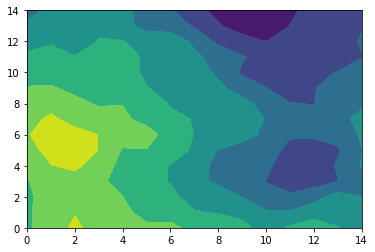

In [57]:
plt.contourf(all_images[index,:,:,i+j])

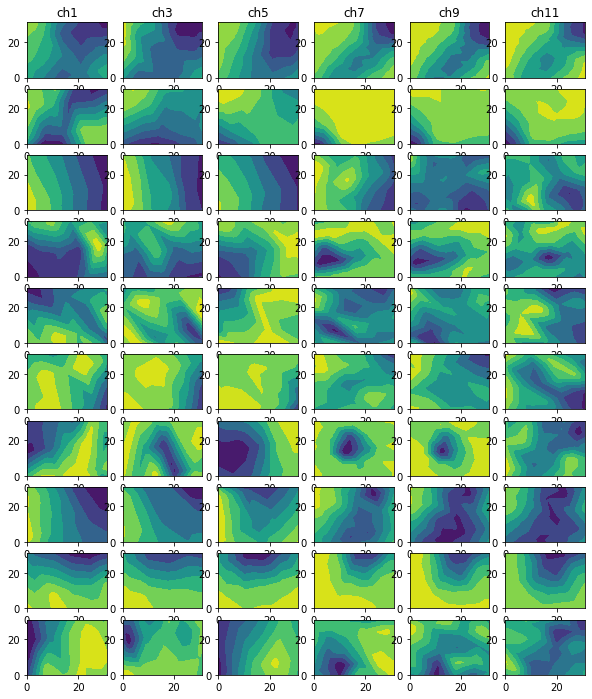

In [65]:
#GPM
high_lc_indices = np.argwhere(all_labels == 1).flatten()
index = high_lc_indices[40:50]
vmin = all_images[index,:,:,6:12].min() # set min/max plotting range  
vmax = all_images[index,:,:,6:12].max()

row = 10
column = 6
fig, ax = plt.subplots(row,column, figsize=(10,12))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i, j].contourf(all_images[index[i],:,:,j+6])
        if i == 0:
            ax[i, j].title.set_text('ch'+str(2*j+1))

In [64]:
vmax

288.97626

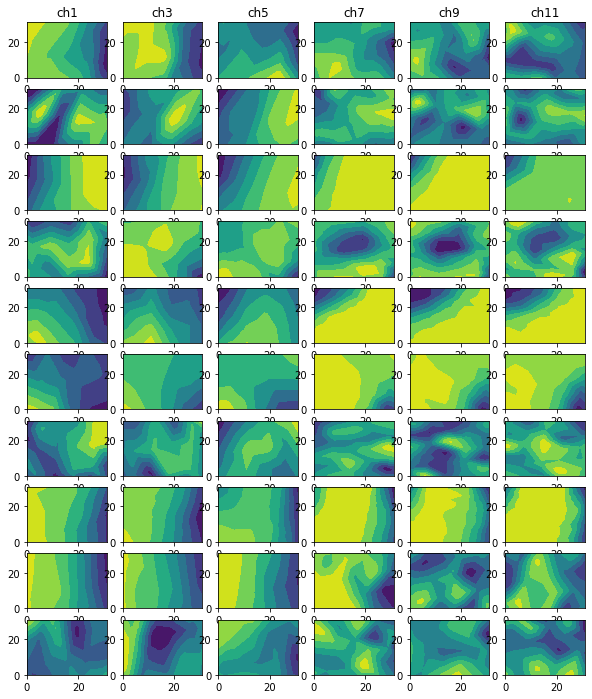

In [58]:
#GPM
high_lc_indices = np.argwhere(all_labels == 0).flatten()
index = high_lc_indices[40:50]
vmin = all_images[index,:,:,6:12].min() # set min/max plotting range  
vmax = all_images[index,:,:,6:12].max()

row = 10
column = 6
fig, ax = plt.subplots(row,column, figsize=(10,12))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i, j].contourf(all_images[index[i],:,:,j+6])
        if i == 0:
            ax[i, j].title.set_text('ch'+str(2*j+1))

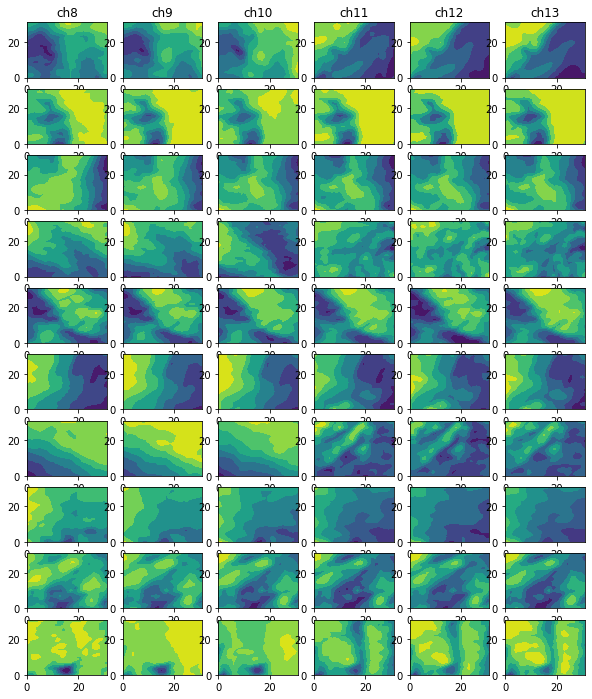

In [59]:
high_lc_indices = np.argwhere(all_labels == 1).flatten()
index = high_lc_indices[40:50]
vmin = all_images[index,:,:,0:6].min() # set min/max plotting range  
vmax = all_images[index,:,:,0:6].max()

row = 10
column = 6
fig, ax = plt.subplots(row,column, figsize=(10,12))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i, j].contourf(all_images[index[i],:,:,j])
        if i == 0:
            ax[i, j].title.set_text('ch'+str(j+8))
#plt.colorbar(a)

In [6]:
print(np.shape(all_images))

(1144, 15, 15, 6)


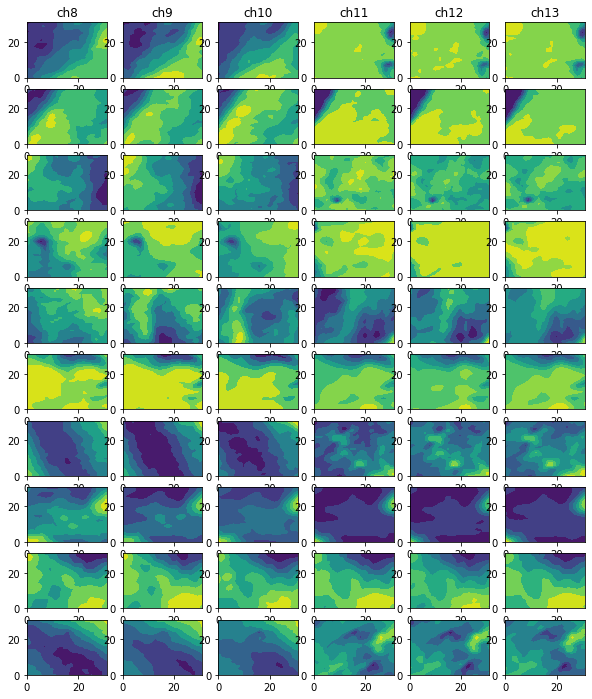

In [60]:
high_lc_indices = np.argwhere(all_labels == 0).flatten()
index = high_lc_indices[40:50]
vmin = all_images[index,:,:,0:6].min() # set min/max plotting range  
vmax = all_images[index,:,:,0:6].max()

row = 10
column = 6
fig, ax = plt.subplots(row,column, figsize=(10,12))
for i in range(row):
    for j in range(column):
        #all_images[index,:,:,i].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
        a = ax[i, j].contourf(all_images[index[i],:,:,j])
        if i == 0:
            ax[i, j].title.set_text('ch'+str(j+8))

In [27]:
high_lc_indices = np.argwhere(all_labels == 1).flatten()

In [6]:
np.shape(labels_shuffled)

(1972,)

In [3]:
np.shape(all_images)

(1144, 15, 15, 6)

In [83]:
num_ch= range(0,49,7)
a=np.zeros(50)
print(num_ch)
print(a[num_ch])

range(0, 49, 7)
[0. 0. 0. 0. 0. 0. 0.]


In [25]:
np.isnan(all_images).any()

True

In [76]:
print(processed_file.variables['predictor'].shape)

(542, 57, 32, 32)


In [20]:
print(all_images[10:12,:,:,47])

[[[292.49335 291.72162 291.2209  ... 302.6195  303.07007 303.35303]
  [292.7068  291.92944 291.73373 ... 302.42517 302.85294 303.24692]
  [293.21014 292.4234  291.91614 ... 301.99396 302.42157 302.79517]
  ...
  [297.91095 297.8655  297.65686 ... 301.74048 301.70352 301.7968 ]
  [297.5305  297.53076 297.9606  ... 301.71033 301.76923 301.7444 ]
  [297.62585 298.35046 298.75598 ... 301.74777 301.80667 301.8157 ]]

 [[298.89655 300.93985 297.87012 ... 304.78506 305.19266 305.70486]
  [300.03583 297.824   287.7665  ... 305.78003 305.86877 306.2522 ]
  [296.18048 292.90417 291.53912 ... 306.2951  306.29822 306.70782]
  ...
  [265.0107  271.81952 281.3635  ... 258.83713 267.09406 274.79486]
  [262.7311  270.98383 278.89398 ... 266.28647 272.69626 278.1689 ]
  [263.52954 271.81952 282.7846  ... 274.7054  281.40695 284.55737]]]


In [12]:
import random
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [2]:

#seed_everything(4835)
#def main():
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
test_dir = My_dir+'test/'
onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
train_Type_1 = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    train_Type_1.append(processed_file.variables['Type'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
train_Type_0 = np.concatenate(train_Type_1).astype(config["dtype"])
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0:
        delete_row.append(i)
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
train_Type_0 = np.delete(train_Type_0, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    test.append(processed_file.variables['predictor'])
    test_label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    date_1.append(processed_file.variables['date'])
    Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0:
        delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
print(np.shape(all_images))
print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]
train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(test_data))

float32
(56647, 32, 32, 57)
(13747, 32, 32, 57)
(40000, 32, 32, 7)
(13747, 32, 32, 7)


In [100]:
shuffler = np.random.permutation(len(all_images))
shuffler

array([10429,  1190, 43017, ..., 27636, 34624, 32248])

In [59]:
shuffler

array([35506,  6698, 41975, ..., 50267, 22777,  9010])

In [101]:
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]
train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(test_data))

(40000, 32, 32, 7)
(13747, 32, 32, 7)


In [42]:
shuffler = np.random.permutation(len(all_images))
shuffler

array([35506,  6698, 41975, ..., 50267, 22777,  9010])

In [20]:
(np.sum(train_Type_0==3)+np.sum(Type_0==3))/(len(train_Type_0)+len(Type_0))

0.057476489473534675

In [4]:
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)

In [21]:
config["random_seed"]

4835

In [22]:
seed_everything(4835)
shuffler = np.random.permutation(len(all_images))
print(shuffler)

[21119  9109  3501 ... 15190  2474 14086]


In [29]:
train_data.shape

(25000, 32, 32, 7)

In [26]:
a_rot=tf.image.rot90(train_data[:,:,:,1], k=3)

In [28]:
print(a_rot.shape)

(32, 25000, 32)


In [23]:
a=tf.constant([[[1],[2]],
               [[3],[4]]])
print(np.shape(a))

(2, 2, 1)


In [8]:
delete_row =[]
delete_row.append(10)

In [11]:
delete_row.append(11)
print(delete_row)

[10, 11]


In [99]:
num_ch = np.arange(0,42,7)
print(num_ch)

[ 0  7 14 21 28 35]


In [96]:
np.sum(np.isnan(test_data))

1

In [106]:
np.sum(train_label)

8038.0

In [107]:
np.sum(train_label==0)

13962

In [ ]:
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
train_val_split = 25000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)
# Start monitor process
#train_ints = [t.argmax() for t in train_data_scaled]

In [18]:
np.arange(0,7)

array([0, 1, 2, 3, 4, 5, 6])

In [64]:
np.sum(train_label==1)/30000

0.36746666666666666

In [21]:
np.sum(test_label)/5000

0.4208

In [50]:
np.min(train_data_scaled[:,:,:,2])

0.0

In [58]:
np.max(test_data_scaled[:,:,:,7])

0.7717824

In [13]:
import sys
import os
#dir_path = os.path.dirname(os.path.realpath(__file__))
#sys.path.extend([dir_path])
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
#from aimlutils.hyper_opt.base_objective import *
import optuna

In [4]:
class Objective(BaseObjective):

    def __init__(self, config, metric = "val_loss", device = "cpu"):
        # Initialize the base class
        BaseObjective.__init__(self, config, metric, device)

    def train(self, trial, config):

        # Make custom updates to model conf
        # conf = custom_updates(trial, conf)

        #Load data
        My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
        test_dir = My_dir+'test/'
        onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
        testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
        # load data serial
        logging.info("Split training and validation data")
        train = []
        label = []
        test = []
        test_label = []
        benchmark_data = dict()
        # load data serial
        benchmark_data["config"] = config
        for file in onlyfiles:
            processed_file = nc.Dataset(os.path.join(My_dir,file))
            #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
            train.append(processed_file.variables['predictor'])
            label.append(processed_file.variables['label'])
        all_images = np.concatenate(train).astype(config["dtype"])
        all_labels = np.concatenate(label).astype(config["dtype"])
        all_images = np.moveaxis(all_images,1,-1)
        delete_row =[]
        for i in range(len(all_labels)):
            if np.sum(np.isnan(all_images[i,:,:,:]))>0:
                delete_row.append(i)
        all_images = np.delete(all_images, delete_row, 0)
        all_labels = np.delete(all_labels, delete_row, 0)
        delete_row =[]
        for file in testfiles:
            processed_file = nc.Dataset(os.path.join(test_dir,file))
            #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
            test.append(processed_file.variables['predictor'])
            test_label.append(processed_file.variables['label'])
        test_images = np.concatenate(test).astype(config["dtype"])
        test_labels = np.concatenate(test_label).astype(config["dtype"])
        test_images = np.moveaxis(test_images,1,-1)
        for i in range(len(test_labels)):
            if np.sum(np.isnan(test_images[i,:,:,:]))>0:
                delete_row.append(i)
        test_images = np.delete(test_images, delete_row, 0)
        test_labels = np.delete(test_labels, delete_row, 0)
        print(np.shape(all_images))
        print(np.shape(test_images))
        num = np.shape(all_images)[0]
        shuffler = np.random.permutation(len(all_images))
        images_shuffled = all_images[shuffler]
        labels_shuffled = all_labels[shuffler]
        shuffler2 = np.random.permutation(len(test_images))
        test_images_shuffled = test_images[shuffler2]
        test_labels_shuffled = test_labels[shuffler2]
        train_val_split = 25000#25000
        num_ch = np.arange(7,14)#28,35)
        train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
        train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
        val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
        val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
        test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
        test_label = test_labels_shuffled[:].astype(config["dtype"])
        #print("ALL DATA=", all_data)
        scaler = MinMaxScaler2D()
        train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
        val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
        test_data_scaled = 1.0 - scaler.transform(test_data)
    
        benchmark_data = dict()
        # load data serial
        benchmark_data["config"] = config
        benchmark_data["system"] = dict()
        benchmark_data["system"]["hostname"] = platform.node()
        benchmark_data["system"]["platform"] = platform.platform()
        benchmark_data["system"]["python_version"] = platform.python_version()
        benchmark_data["system"]["python_compiler"] = platform.python_compiler()
        benchmark_data["system"]["tensorflow_version"] = tf.__version__
        benchmark_data["system"]["gpus"] = get_gpu_names()
        has_gpus = True
        if len(benchmark_data["system"]["gpus"]) == 0:
            has_gpus = False
        #benchmark_data["system"].update(**get_cuda_version())
        benchmark_data["system"]["cudnn_version"] = get_cudnn_version()
        benchmark_data["system"]["nccl_version"] = get_nccl_version()
        benchmark_data["system"]["gpu_topology"] = get_gpu_topo()
        has_gpus = True
        out_path = '/glade/work/fanda/optimization'
        #print("Training Data==",train_data)
        parent_p, child_p = Pipe()
        dl_monitor = Monitor(child_p)
        monitor_proc = Process(target=dl_monitor.run)
        monitor_proc.start()
        batch_loss = None
        epoch_loss = None
        trial = None
        try:
            # Build model (Single GPU Training)
            if config["single_gpu"] and has_gpus:
                logging.info("Single GPU Training")
                block_name = "gpu_{0:02d}_training".format(1)
                start_timing(benchmark_data, block_name, parent_p, out_path)
                epoch_times, batch_loss, epoch_loss = train_conv_net_gpu(train_data_scaled, train_label,
                                val_data_scaled, val_label, config["conv_net_parameters"],
                                1, config["random_seed"], dtype=config["dtype"],trial=trial)#,monitor='val_loss')
                end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
                benchmark_data[block_name]["batch_loss"] = batch_loss
                benchmark_data[block_name]["epoch_loss"] = epoch_loss

            # Save benchmark data
            parent_p.send("exit")
            monitor_proc.join()
            output_filename = str(join(config["out_path"], "goes_benchmark_data_{0}.yml".format(datetime.utcnow().strftime("%Y%m%d_%H%M%S"))))
            logging.info("Saving benchmark data to {output_filename}".format(output_filename=output_filename))
            with open(output_filename, "w") as output_file:
                yaml.dump(benchmark_data, output_file,Dumper=yaml.Dumper)
            print_summary(benchmark_data)
        except Exception as e:
            logging.error(traceback.format_exc())
            parent_p.send("exit")
            monitor_proc.join()
            sys.exit()
        return epoch_loss

    def print_summary(benchmark_data):
        logging.info("*** GOES Summary ***")
        if "cpu_training" in benchmark_data.keys():
            logging.info("CPU Training")
            logging.info("Elapsed: {0:0.2f}".format(benchmark_data["cpu_training"]["elapsed_duration"]))
            logging.info("Epoch: {0:0.2f}".format(benchmark_data["cpu_training"]["epoch_duration"]))
            logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data["cpu_training"]["epoch_duration"]
                                                          / benchmark_data["cpu_training"]["elapsed_duration"]))
            logging.info("\n")
        for gpu in [1, 2, 4, 8]:
            block_name = "gpu_{0:02d}_training".format(gpu)
            if block_name in benchmark_data.keys():
                logging.info("{0:02d} GPU Training".format(gpu))
                logging.info("Elapsed: {0:0.2f}".format(benchmark_data[block_name]["elapsed_duration"]))
                logging.info("Epoch: {0:0.2f}".format(benchmark_data[block_name]["epoch_duration"]))
                logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data[block_name]["epoch_duration"]
                                                              / benchmark_data[block_name]["elapsed_duration"]))
                logging.info("\n")

        return

In [10]:
print(config["conv_net_parameters"])

{'min_filters': 16, 'use_dropout': 1, 'dropout_alpha': 0.2, 'verbose': 1, 'epochs': 40, 'pooling': 'mean', 'learning_rate': 0.0001, 'batch_size': 1024, 'loss': 'binary_crossentropy', 'metrics': ['binary_crossentropy', 'AUC']}


In [7]:
tf.__version__[0]
tf.random.set_seed(1234)

In [9]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"


In [102]:
def main():
    config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best.yml',"r")
    config = yaml.load(config_file, Loader=yaml.Loader)
    benchmark_data = dict()
    # load data serial
    benchmark_data["config"] = config
    benchmark_data["system"] = dict()
    benchmark_data["system"]["hostname"] = platform.node()
    benchmark_data["system"]["platform"] = platform.platform()
    benchmark_data["system"]["python_version"] = platform.python_version()
    benchmark_data["system"]["python_compiler"] = platform.python_compiler()
    benchmark_data["system"]["tensorflow_version"] = tf.__version__
    benchmark_data["system"]["gpus"] = get_gpu_names()
    has_gpus = True
    if len(benchmark_data["system"]["gpus"]) == 0:
        has_gpus = False
    #benchmark_data["system"].update(**get_cuda_version())
    benchmark_data["system"]["cudnn_version"] = get_cudnn_version()
    benchmark_data["system"]["nccl_version"] = get_nccl_version()
    benchmark_data["system"]["gpu_topology"] = get_gpu_topo()
    has_gpus = True
    out_path = '/glade/work/fanda/optimization'
    #print("Training Data==",train_data)
    parent_p, child_p = Pipe()
    dl_monitor = Monitor(child_p)
    monitor_proc = Process(target=dl_monitor.run)
    monitor_proc.start()
    batch_loss = None
    epoch_loss = None
    trial = None
    try:
        # CPU training
        if config["cpu"]:
            logging.info("CPU Training")
            block_name = "cpu_training"
            start_timing(benchmark_data, block_name, parent_p, out_path)
            epoch_times, batch_loss, epoch_loss = train_conv_net_cpu(train_data_scaled, train_label,
                            test_data_scaled, test_label, config["conv_net_parameters"],
                                             config["num_cpus"], config["random_seed"],trial=trial)
            end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
            benchmark_data[block_name]["batch_loss"] = batch_loss
            benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # CPU inference

        # Multi GPU Training
        if config["multi_gpu"] and has_gpus:
            gpu_nums = np.array([2, 4, 8])
            gpu_nums = gpu_nums[gpu_nums <= np.minimum(config["num_gpus"], len(benchmark_data["system"]["gpus"]))]
            for gpu_num in gpu_nums:
                block_name = "gpu_{0:02d}_training".format(gpu_num)
                logging.info("Multi GPU Training {0:02d}".format(gpu_num))
                start_timing(benchmark_data, block_name, parent_p, out_path)
                epoch_times, batch_loss, epoch_loss = train_conv_net_gpu(train_data_scaled, train_counts,
                                                 val_data_scaled, val_counts, config["conv_net_parameters"],
                                                 gpu_num, config["random_seed"], dtype=config["dtype"], scale_batch_size=scale_batch_size,trial=trial)
                end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
                benchmark_data[block_name]["batch_loss"] = batch_loss
                benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # Single GPU Training
        if config["single_gpu"] and has_gpus:
            #train_label_one_hot = tf.one_hot(train_label, 2).numpy()
            #test_label_one_hot = tf.one_hot(test_label, 2).numpy()            
            logging.info("Single GPU Training")
            block_name = "gpu_{0:02d}_training".format(1)
            start_timing(benchmark_data, block_name, parent_p, out_path)
            epoch_times, batch_loss, epoch_loss = train_conv_net_gpu(train_data_scaled, train_label,
                            val_data_scaled, val_label, config["conv_net_parameters"],
                            1, config["random_seed"], dtype=config["dtype"], trial=trial)#,monitor='val_loss')
            end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
            benchmark_data[block_name]["batch_loss"] = batch_loss
            benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # Save benchmark data
        parent_p.send("exit")
        monitor_proc.join()
        output_filename = str(join(config["out_path"], "goes_benchmark_data_{0}.yml".format(datetime.utcnow().strftime("%Y%m%d_%H%M%S"))))
        logging.info("Saving benchmark data to {output_filename}".format(output_filename=output_filename))
        with open(output_filename, "w") as output_file:
            yaml.dump(benchmark_data, output_file,Dumper=yaml.Dumper)
        print_summary(benchmark_data)
    except Exception as e:
        logging.error(traceback.format_exc())
        parent_p.send("exit")
        monitor_proc.join()
        sys.exit()

def print_summary(benchmark_data):
    logging.info("*** GOES Summary ***")
    if "cpu_training" in benchmark_data.keys():
        logging.info("CPU Training")
        logging.info("Elapsed: {0:0.2f}".format(benchmark_data["cpu_training"]["elapsed_duration"]))
        logging.info("Epoch: {0:0.2f}".format(benchmark_data["cpu_training"]["epoch_duration"]))
        logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data["cpu_training"]["epoch_duration"]
                                                      / benchmark_data["cpu_training"]["elapsed_duration"]))
        logging.info("\n")
    for gpu in [1, 2, 4, 8]:
        block_name = "gpu_{0:02d}_training".format(gpu)
        if block_name in benchmark_data.keys():
            logging.info("{0:02d} GPU Training".format(gpu))
            logging.info("Elapsed: {0:0.2f}".format(benchmark_data[block_name]["elapsed_duration"]))
            logging.info("Epoch: {0:0.2f}".format(benchmark_data[block_name]["epoch_duration"]))
            logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data[block_name]["epoch_duration"]
                                                          / benchmark_data[block_name]["elapsed_duration"]))
            logging.info("\n")

    return
    
if __name__ == "__main__":
    main()

Epoch 1/50
149/149 [==============================] - 9s 55ms/step - loss: 1.3096 - binary_crossentropy: 1.0910 - auc: 0.6857 - val_loss: 0.7064 - val_binary_crossentropy: 0.7064 - val_auc: 0.7566
{'loss': 0.9482249021530151, 'binary_crossentropy': 0.7714311480522156, 'auc': 0.7283161878585815, 'val_loss': 0.7064331769943237, 'val_binary_crossentropy': 0.7064331769943237, 'val_auc': 0.7565969824790955}
Epoch 2/50
149/149 [==============================] - 8s 51ms/step - loss: 0.7531 - binary_crossentropy: 0.5964 - auc: 0.7757 - val_loss: 0.9062 - val_binary_crossentropy: 0.9062 - val_auc: 0.7331
{'loss': 0.7385386228561401, 'binary_crossentropy': 0.5883532166481018, 'auc': 0.7811985015869141, 'val_loss': 0.906246542930603, 'val_binary_crossentropy': 0.906246542930603, 'val_auc': 0.7330909967422485}
Epoch 3/50
149/149 [==============================] - 8s 51ms/step - loss: 0.7163 - binary_crossentropy: 0.5721 - auc: 0.7953 - val_loss: 0.6300 - val_binary_crossentropy: 0.6300 - val_auc: 

In [103]:
my_model = tf.keras.models.load_model("goes16_resnet_gpus_01.h5",compile=False)

In [104]:
binary_threshold = 0.5
preds = my_model.predict(test_data_scaled).reshape(test_label.shape)
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [105]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(F)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return POD, POFD, FAR, SR, CSI
#tn, fp, fn, tp
def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [106]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),4)))

RMSE: 0.39500001072883606
R squared: 0.401
Hellenger Distance: 0.486
2478
POD: 0.9179373440532298, POFD: 0.3793050665850298, FAR: 0.2723076923076923, SR: 0.7276923076923076, CSI:0.6832439125051589
Heidke Skill Score: 0.546
[[4055 2478]
 [ 592 6622]]
Pierce Skill Score: 0.539
Brier Score: 0.223
Brier Skill Score: 0.374
Accuracy score: 0.777
AUC: 0.8585


In [78]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),4)))

RMSE: 0.4000000059604645
R squared: 0.387
Hellenger Distance: 0.525
2647
POD: 0.9266703631827004, POFD: 0.4051737333537425, FAR: 0.28364766395199315, SR: 0.7163523360480069, CSI:0.6779231315282426
Heidke Skill Score: 0.53
[[3886 2647]
 [ 529 6685]]
Pierce Skill Score: 0.521
Brier Score: 0.231
Brier Skill Score: 0.36
Accuracy score: 0.769
AUC: 0.8507


In [ ]:
RMSE: 0.39100000262260437
R squared: 0.413
Hellenger Distance: 0.455
2330
POD: 0.9121153313002495, POFD: 0.35665084953313947, FAR: 0.2615039281705948, SR: 0.7384960718294051, CSI:0.6894383906119028
Heidke Skill Score: 0.562
[[4203 2330]
 [ 634 6580]]
Pierce Skill Score: 0.555
Brier Score: 0.216
Brier Skill Score: 0.388
Accuracy score: 0.784
AUC: 0.8642

In [51]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),4)))

RMSE: 0.39100000262260437
R squared: 0.413
Hellenger Distance: 0.455
2330
POD: 0.9121153313002495, POFD: 0.35665084953313947, FAR: 0.2615039281705948, SR: 0.7384960718294051, CSI:0.6894383906119028
Heidke Skill Score: 0.562
[[4203 2330]
 [ 634 6580]]
Pierce Skill Score: 0.555
Brier Score: 0.216
Brier Skill Score: 0.388
Accuracy score: 0.784
AUC: 0.8642


In [58]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),4)))

RMSE: 0.4059999883174896
R squared: 0.368
Hellenger Distance: 0.556
2743
POD: 0.9255614083726088, POFD: 0.4198683606306444, FAR: 0.29118895966029723, SR: 0.7088110403397028, CSI:0.670583509089083
Heidke Skill Score: 0.514
[[3790 2743]
 [ 537 6677]]
Pierce Skill Score: 0.506
Brier Score: 0.239
Brier Skill Score: 0.339
Accuracy score: 0.761
AUC: 0.8415


In [56]:
my_model = tf.keras.models.load_model("goes16_resnet_gpus_01_baseline.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})

In [25]:
import scipy.io as scio
scio.savemat('test_lead10_allIR_JuneJuly.mat',{'test_data_scaled':test_data_scaled,'test_label':test_label})

In [5]:

print(my_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 6)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 16)   880         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d_3[0][0]                   
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 16)   0           bn_res_00_a[0][0]                
_______________________________________________________________________________________

In [36]:
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
resNet_mod = ResNet(epochs=30, batch_size=512, loss='binary_crossentropy', pooling= 'mean', metrics='AUC', use_dropout='True',dropout_alpha=0.2,)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': 'True',
 'pooling': 'mean',
 'dropout_alpha': 0.2,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'binary_crossentropy',
 'metrics': 'AUC',
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 30,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x2b543a17d850>,
 'loss_history': <goes16ci.models.LossHistory at 0x2b543a17d910>,
 'verbose': 0}

In [37]:
resNet_mod.fit(train_data_scaled, train_label, test_data_scaled, test_label)
resNet_mod.model.summary()

{'loss': 0.7633802890777588, 'auc': 0.5839452147483826, 'val_loss': 0.675493061542511, 'val_auc': 0.6191078424453735}
{'loss': 0.6664043664932251, 'auc': 0.6327058672904968, 'val_loss': 0.6762506365776062, 'val_auc': 0.6267576813697815}
{'loss': 0.6572539210319519, 'auc': 0.6463538408279419, 'val_loss': 0.67176753282547, 'val_auc': 0.6198052763938904}
{'loss': 0.6525751352310181, 'auc': 0.6546316146850586, 'val_loss': 0.6673116683959961, 'val_auc': 0.6326120495796204}
{'loss': 0.6453123092651367, 'auc': 0.6664975881576538, 'val_loss': 0.669141948223114, 'val_auc': 0.6405338048934937}
{'loss': 0.6431494951248169, 'auc': 0.6707132458686829, 'val_loss': 0.65683513879776, 'val_auc': 0.6467249393463135}
{'loss': 0.6408835053443909, 'auc': 0.6747090816497803, 'val_loss': 0.6630051732063293, 'val_auc': 0.6331604719161987}
{'loss': 0.6369785666465759, 'auc': 0.6833467483520508, 'val_loss': 0.6485397219657898, 'val_auc': 0.6622041463851929}
{'loss': 0.6337387561798096, 'auc': 0.6868913769721985

KeyboardInterrupt: 

In [ ]:
AUC
GOES-only: 0.54
GPM-only: 0.77
HRRR-only: 0.



In [4]:
from roc_utils import *
import numpy as np

In [2]:
def sample_data(n1, mu1, std1, n2, mu2, std2, seed=42):
    """
    Construct binary classification problem with n1 and n2 
    samples per class, respectively. 
    
    Returns two np.ndarrays x and y of length (n1+n2). 
    x represents the predictor, y the binary response.
    """
    rng = np.random.RandomState(seed)
    #  sample size, mean, std
    x1 = rng.normal(mu1, std1, n1)
    x2 = rng.normal(mu2, std2, n2)
    y1 = np.zeros(n1, dtype=bool)
    y2 = np.ones(n2, dtype=bool)
    x = np.concatenate([x1,x2])
    y = np.concatenate([y1,y2])
    return x, y

In [ ]:
x

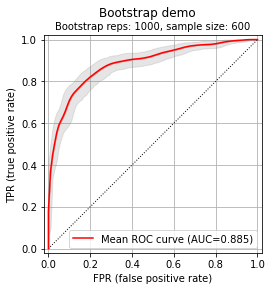

In [10]:
pos_label = True
n_samples = 1000
x, y = sample_data(n1=300, mu1=0.0, std1=0.5,
                   n2=300, mu2=1.0, std2=0.7)
plot_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                   n_bootstrap=n_samples,
                   random_state=42,
                   show_boots=False,
                   title="Bootstrap demo");

In [44]:
import pandas as pd
val_his = pd.read_csv("AUC_history.csv")
val_his.head()

,loss,[0.6497853398323059,0.5777354836463928,0.5555954575538635,0.5403953790664673,0.5339959263801575,0.527998149394989,0.5230703353881836,0.5198696255683899,0.5159423351287842,...,0.5117298364639282,0.5074593424797058,0.5084346532821655,0.5034458637237549,0.5008417367935181,0.4972785711288452,0.49759581685066223,0.49406737089157104,0.49141520261764526,0.4876770079135895]
0,binary_crossentropy,[0.6497853398323059,0.577735,0.555595,0.540395,0.533996,0.527998,0.523070,0.519870,0.515942,...,0.511730,0.507459,0.508435,0.503446,0.500842,0.497279,0.497596,0.494067,0.491415,0.4876770079135895]
1,auc,[0.630468487739563,0.721253,0.742230,0.759275,0.767145,0.773358,0.777431,0.781050,0.784323,...,0.789011,0.793431,0.791474,0.797005,0.799150,0.803435,0.802299,0.806804,0.809333,0.8120964169502258]
2,val_loss,[0.6832836866378784,0.681238,0.672185,0.651608,0.623729,0.630239,0.663375,0.691583,0.709317,...,0.720652,0.645443,0.580589,0.530658,0.546293,0.562239,0.525409,0.551283,0.523112,0.557205080986023]
3,val_binary_crossentropy,[0.6832836866378784,0.681238,0.672185,0.651608,0.623729,0.630239,0.663375,0.691583,0.709317,...,0.720652,0.645443,0.580589,0.530658,0.546293,0.562239,0.525409,0.551283,0.523112,0.557205080986023]
4,val_auc,[0.44336193799972534,0.448840,0.558904,0.621285,0.665227,0.677430,0.693324,0.697743,0.712747,...,0.749300,0.760899,0.767832,0.769779,0.771034,0.776975,0.781410,0.773752,0.787062,0.7729336023330688]


In [122]:
import pandas as pd
val_his = pd.read_csv("AUC_history.csv")
AUC = val_his.iloc[1,:]
val_auc = val_his.iloc[4,:]
Train_AUC = []
Val_ACU = []
for i in AUC[1:]:
    temp = str(i).strip('[').strip(']')
    Train_AUC.append(float(temp))
for i in val_auc[1:]:
    temp = str(i).strip('[').strip(']')
    Val_ACU.append(float(temp))


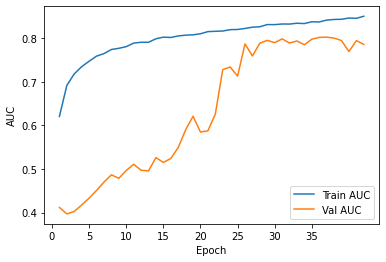

In [124]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,np.size(Train_AUC)+1)
#val_mean_squared_error_1cpu=val_his[]
#val_mean_squared_error_4cpu=[0.44336193799972534, 0.4488404095172882, 0.5589040517807007, 0.6212853789329529, 0.6652269959449768, 0.6774303317070007, 0.6933239102363586, 0.6977429986000061, 0.7127474546432495, 0.7368190288543701, 0.7493003606796265, 0.7608986496925354, 0.7678315043449402, 0.7697786688804626, 0.7710341215133667, 0.7769752144813538, 0.781409740447998, 0.7737517952919006, 0.7870616316795349, 0.7729336023330688]
plt.plot(epoch, Train_AUC)
plt.plot(epoch, Val_ACU)
plt.legend(['Train AUC','Val AUC'])
plt.xticks(np.arange(0, 40, step=5))
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [118]:
max(Val_ACU)

0.8206919431686401

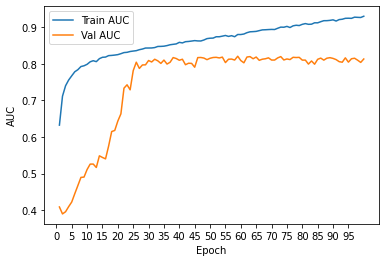

In [117]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,np.size(Train_AUC)+1)
#val_mean_squared_error_1cpu=val_his[]
#val_mean_squared_error_4cpu=[0.44336193799972534, 0.4488404095172882, 0.5589040517807007, 0.6212853789329529, 0.6652269959449768, 0.6774303317070007, 0.6933239102363586, 0.6977429986000061, 0.7127474546432495, 0.7368190288543701, 0.7493003606796265, 0.7608986496925354, 0.7678315043449402, 0.7697786688804626, 0.7710341215133667, 0.7769752144813538, 0.781409740447998, 0.7737517952919006, 0.7870616316795349, 0.7729336023330688]
plt.plot(epoch, Train_AUC)
plt.plot(epoch, Val_ACU)
plt.legend(['Train AUC','Val AUC'])
plt.xticks(np.arange(0, 100, step=5))
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

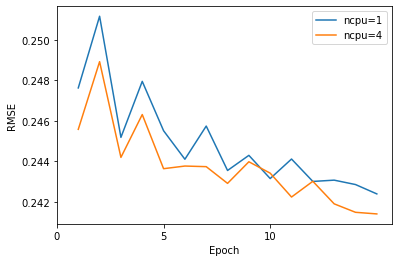

In [8]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,16)
val_mean_squared_error_1cpu=[0.24762912094593048, 0.25116780400276184, 0.24518859386444092, 0.24795278906822205, 0.2455170750617981, 0.24410925805568695,\
                        0.2457471787929535, 0.2435547560453415, 0.24430130422115326, 0.24315588176250458, 0.24411983788013458, 0.24301357567310333, \
                        0.24307729303836823, 0.24286054074764252, 0.2423982322216034]
val_mean_squared_error_4cpu=[0.24558548629283905, 0.24892574548721313, 0.24420025944709778, 0.2463153898715973, 0.24364298582077026, 0.2437734305858612,\
                             0.24374336004257202, 0.24291828274726868, 0.24398469924926758, 0.24342210590839386, 0.24224412441253662, 0.2430204451084137, \
                             0.2419077605009079, 0.24149034917354584, 0.24141058325767517]
plt.plot(epoch, val_mean_squared_error_1cpu)
plt.plot(epoch, val_mean_squared_error_4cpu)
plt.legend(['ncpu=1','ncpu=4'])
plt.xticks(np.arange(0, 15, step=5))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()